In [37]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (10, 5)

In [38]:
docs = [
    "The cat sat on the mat and looked at the moon.",
    "Dogs are loyal animals and they love to play fetch.",
    "The quick brown fox jumps over the lazy dog.",
    "I love machine learning and natural language processing.",
    "Deep learning models can learn complex patterns from data.",
    "The economy is affected by inflation and interest rates.",
    "Stock markets fluctuate based on news and investor sentiment.",
    "A healthy diet includes fruits vegetables and whole grains.",
    "Regular exercise improves cardiovascular health and mood.",
    "Python is a popular language for data science and AI."
]

In [39]:
query = "machine learning with python for language processing"

In [40]:
def preprocess(text, lowercase=True, remove_stopwords=True):
    if lowercase:
        text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()

    if remove_stopwords:
        tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]

    return tokens

LOWERCASE = True
REMOVE_STOPWORDS = True

doc_tokens = [preprocess(d, LOWERCASE, REMOVE_STOPWORDS) for d in docs]
query_tokens = preprocess(query, LOWERCASE, REMOVE_STOPWORDS)

print("Sample document tokens (doc0):", doc_tokens[0])
print("Query tokens:", query_tokens)

Sample document tokens (doc0): ['cat', 'sat', 'mat', 'looked', 'moon']
Query tokens: ['machine', 'learning', 'python', 'language', 'processing']


In [41]:
vocab = sorted(set(token for tokens in doc_tokens for token in tokens))
vocab_index = {t:i for i,t in enumerate(vocab)}
V = len(vocab)

print("\nVocabulary size:", V)
print("First 25 vocab terms:", vocab[:25])


Vocabulary size: 55
First 25 vocab terms: ['affected', 'ai', 'animals', 'based', 'brown', 'cardiovascular', 'cat', 'complex', 'data', 'deep', 'diet', 'dog', 'dogs', 'economy', 'exercise', 'fetch', 'fluctuate', 'fox', 'fruits', 'grains', 'health', 'healthy', 'improves', 'includes', 'inflation']


In [42]:
def term_freq(tokens, vocab_index):
    vec = np.zeros(len(vocab_index), dtype=float)
    for t in tokens:
        if t in vocab_index:
            vec[vocab_index[t]] += 1.0
    return vec

tf_docs = np.vstack([term_freq(tokens, vocab_index) for tokens in doc_tokens])
tf_query = term_freq(query_tokens, vocab_index)

tf_df = pd.DataFrame(tf_docs, columns=vocab)
tf_df.index = [f"D{i}" for i in range(len(docs))]

print("\nTF table (showing first 12 terms):")
display(tf_df.iloc[:, :12].head())


TF table (showing first 12 terms):


,affected,ai,animals,based,brown,cardiovascular,cat,complex,data,deep,diet,dog
D0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
D1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
D3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [43]:
df = (tf_docs > 0).sum(axis=0)

N = len(docs)

idf = -np.log(N / df)

df_idf = pd.DataFrame({
    "term": vocab,
    "df": df,
    "idf": idf
}).sort_values(by="idf", ascending=False)

print("\nDF + IDF (top 15 highest-IDF terms):")
display(df_idf.head(15))


DF + IDF (top 15 highest-IDF terms):


,term,df,idf
8,data,2,-1.609438
27,language,2,-1.609438
30,learning,2,-1.609438
32,love,2,-1.609438
3,based,1,-2.302585
1,ai,1,-2.302585
0,affected,1,-2.302585
6,cat,1,-2.302585
7,complex,1,-2.302585
9,deep,1,-2.302585


In [44]:
tfidf_docs = tf_docs * idf
tfidf_query = tf_query * idf

tfidf_df = pd.DataFrame(tfidf_docs, columns=vocab, index=tf_df.index)

print("\nTF-IDF table (showing first 12 terms):")
display(tfidf_df.iloc[:, :12].head())


TF-IDF table (showing first 12 terms):


,affected,ai,animals,based,brown,cardiovascular,cat,complex,data,deep,diet,dog
D0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-2.302585,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
D1,-0.0,-0.0,-2.302585,-0.0,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
D2,-0.0,-0.0,-0.000000,-0.0,-2.302585,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-2.302585
D3,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
D4,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-2.302585,-1.609438,-2.302585,-0.0,-0.000000


In [45]:
def cosine_similarity_matrix(A, b):
    """
    cosine(A_i, b) for each row A_i
    """
    A_norm = np.linalg.norm(A, axis=1) + 1e-12
    b_norm = np.linalg.norm(b) + 1e-12
    return (A @ b) / (A_norm * b_norm)

cos_scores = cosine_similarity_matrix(tfidf_docs, tfidf_query)

ranking = pd.DataFrame({
    "doc_id": tf_df.index,
    "cosine_score": cos_scores,
    "document": docs
}).sort_values(by="cosine_score", ascending=False)

print("\nRanking (highest cosine similarity first):")
display(ranking)


Ranking (highest cosine similarity first):


,doc_id,cosine_score,document
3,D3,0.706428,I love machine learning and natural language p...
9,D9,0.334575,Python is a popular language for data science ...
4,D4,0.100204,Deep learning models can learn complex pattern...
0,D0,0.000000,The cat sat on the mat and looked at the moon.
1,D1,0.000000,Dogs are loyal animals and they love to play f...
2,D2,0.000000,The quick brown fox jumps over the lazy dog.
5,D5,0.000000,The economy is affected by inflation and inter...
6,D6,0.000000,Stock markets fluctuate based on news and inve...
7,D7,0.000000,A healthy diet includes fruits vegetables and ...
8,D8,0.000000,Regular exercise improves cardiovascular healt...


In [46]:
query_terms_in_vocab = [t for t in query_tokens if t in vocab_index]
query_terms_in_vocab = sorted(set(query_terms_in_vocab), key=lambda x: query_terms_in_vocab.index(x))

print("\nQuery terms (that exist in vocab):", query_terms_in_vocab)

qt = pd.DataFrame({
    "term": query_terms_in_vocab,
    "tf_query": [tf_query[vocab_index[t]] for t in query_terms_in_vocab],
    "idf": [idf[vocab_index[t]] for t in query_terms_in_vocab],
    "tfidf_query": [tfidf_query[vocab_index[t]] for t in query_terms_in_vocab],
}).sort_values(by="tfidf_query", ascending=False)

print("\nQuery term weights:")
display(qt)

top_doc_id = ranking.iloc[0]["doc_id"]
top_doc_vec = tfidf_df.loc[top_doc_id]

doc_contrib = pd.DataFrame({
    "term": query_terms_in_vocab,
    "tfidf_doc": [top_doc_vec[t] for t in query_terms_in_vocab],
    "tfidf_query": [tfidf_query[vocab_index[t]] for t in query_terms_in_vocab],
})
doc_contrib["product"] = doc_contrib["tfidf_doc"] * doc_contrib["tfidf_query"]
doc_contrib = doc_contrib.sort_values(by="product", ascending=False)

print(f"\nTerm-by-term contribution (product of TF-IDF) for top doc = {top_doc_id}:")
display(doc_contrib)


Query terms (that exist in vocab): ['machine', 'learning', 'python', 'language', 'processing']

Query term weights:


,term,tf_query,idf,tfidf_query
1,learning,1.0,-1.609438,-1.609438
3,language,1.0,-1.609438,-1.609438
0,machine,1.0,-2.302585,-2.302585
2,python,1.0,-2.302585,-2.302585
4,processing,1.0,-2.302585,-2.302585



Term-by-term contribution (product of TF-IDF) for top doc = D3:


,term,tfidf_doc,tfidf_query,product
0,machine,-2.302585,-2.302585,5.301898
4,processing,-2.302585,-2.302585,5.301898
1,learning,-1.609438,-1.609438,2.590290
3,language,-1.609438,-1.609438,2.590290
2,python,-0.000000,-2.302585,0.000000


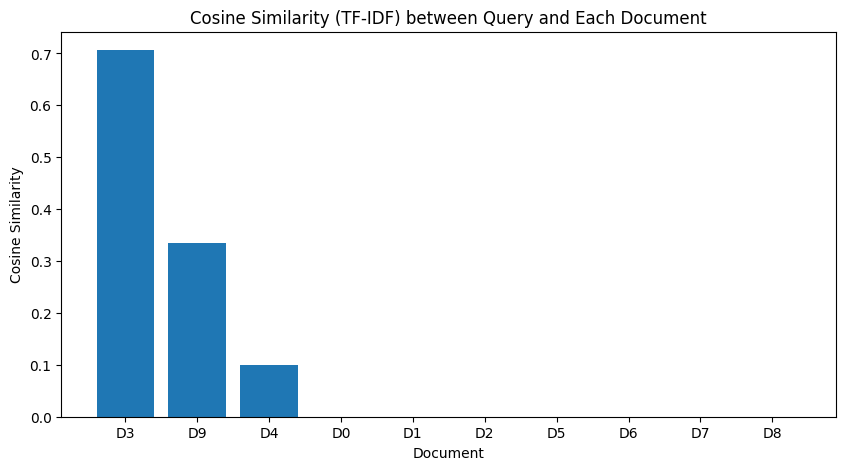

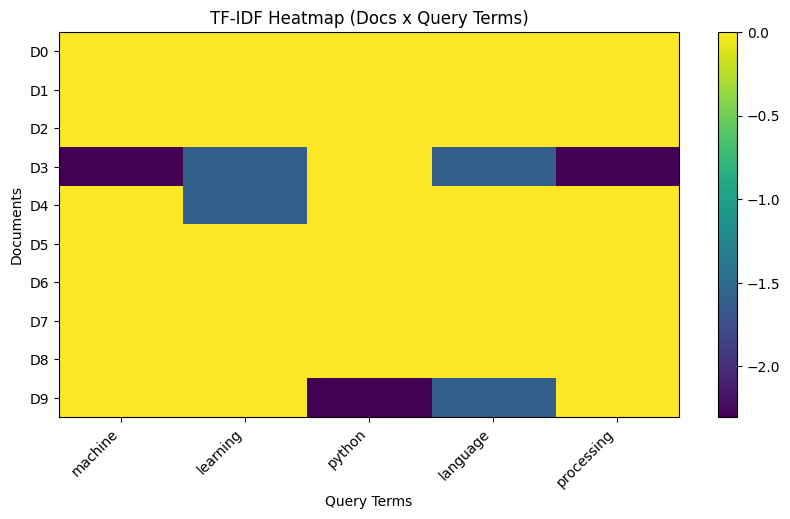

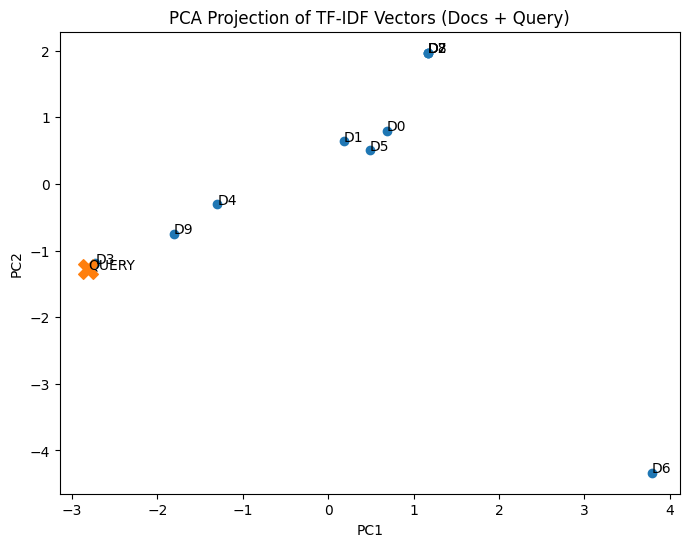

In [47]:
plt.figure()
plt.bar(ranking["doc_id"], ranking["cosine_score"])
plt.title("Cosine Similarity (TF-IDF) between Query and Each Document")
plt.xlabel("Document")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=0)
plt.show()

if len(query_terms_in_vocab) > 0:
    heat = tfidf_df[query_terms_in_vocab].copy()
    plt.figure(figsize=(10, 5))
    plt.imshow(heat.values, aspect="auto")
    plt.title("TF-IDF Heatmap (Docs x Query Terms)")
    plt.xlabel("Query Terms")
    plt.ylabel("Documents")
    plt.xticks(range(len(query_terms_in_vocab)), query_terms_in_vocab, rotation=45, ha="right")
    plt.yticks(range(len(heat.index)), heat.index)
    plt.colorbar()
    plt.show()
else:
    print("No query terms found in vocabulary after preprocessing; heatmap skipped.")

X = np.vstack([tfidf_docs, tfidf_query.reshape(1, -1)])
labels = [f"D{i}" for i in range(N)] + ["QUERY"]

pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X2[:N, 0], X2[:N, 1])
plt.scatter(X2[N, 0], X2[N, 1], marker="X", s=200)

for i in range(N):
    plt.text(X2[i, 0], X2[i, 1], f"D{i}")
plt.text(X2[N, 0], X2[N, 1], "QUERY")

plt.title("PCA Projection of TF-IDF Vectors (Docs + Query)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def sklearn_tokenizer(text):
    return preprocess(text, LOWERCASE, REMOVE_STOPWORDS)

vectorizer = TfidfVectorizer(tokenizer=sklearn_tokenizer, lowercase=False)
X_sk = vectorizer.fit_transform(docs)
q_sk = vectorizer.transform([query])

scores_sk = cosine_similarity(X_sk, q_sk).ravel()
ranking_sk = pd.DataFrame({
    "doc_id": [f"D{i}" for i in range(N)],
    "cosine_score_sklearn": scores_sk
}).sort_values(by="cosine_score_sklearn", ascending=False)

print("\nScikit-learn verification (ranking):")
display(ranking_sk)


Scikit-learn verification (ranking):


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,doc_id,cosine_score_sklearn
3,D3,0.718816
9,D9,0.350135
4,D4,0.135008
0,D0,0.000000
1,D1,0.000000
2,D2,0.000000
5,D5,0.000000
6,D6,0.000000
7,D7,0.000000
8,D8,0.000000
